In [11]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

In [6]:
#### Define Kernel ####

@np.vectorize 
def cubic_spline(r, h, order):
    
    q = float(abs(r))/h
    sigma = float(2.0 / (3.0 * h))
    if order == 0:
        if q <=1.0 and q >=0.0: 
            return sigma * (1.0 - (1.5 * q * q) + (0.75 * q * q * q))
        elif q > 1.0 and q <= 2.0:
            return sigma * 0.25 * ((2.0 - q) ** 3.0)
        else:
            return 0.0
    else:
        diff_multiplier = float(np.sign(r) / h)
        if q <=1.0 and q >=0.0: 
            return float(sigma * ((-3.0 * q) + (2.25 * q * q)) * diff_multiplier)
        elif q > 1.0 and q <= 2.0:
            return float(sigma * -0.75 * ((2 - q) ** 2) * diff_multiplier)
        else:
            return 0.0

In [50]:
class Shocktube(object):
    
    ### Need to add solid boundaries ? ###
    
    def __init__(self, x, p, rho, v, m, h, gamma, epsilon, eta, kernel, tag):
        
        self.x = x
        self.p = p
        self.rho = rho
        self.e = p / ((gamma - 1) * rho)
        self.m = m
        self.h = h
        self.gamma = gamma
        self.epsilon = epsilon
        self.eta = eta
        self.kernel = kernel
        self.v = v
        self.tag = tag # 1 is real, 0 is ghost
        
    #### For a particle at index i, get arrays ####
        
    def get_vij(self, i):
        return self.v[i] - self.v
    
    def get_dwij(self, i):
        return self.kernel(self.x[i] - self.x, self.h, order = 1)
    
    def get_wij(self, i):
        return self.kernel(self.x[i] - self.x, self.h, order = 0)
    
    def get_xij(self, i):
        return self.x[i] - self.x
    
    def get_pi_ij(self, i):
        ci = (self.gamma * self.p[i] / self.rho[i]) ** 0.5
        cj = (self.gamma * self.p / self.rho) ** 0.5
        cij = 0.5 * (ci + cj)
        rhoij = 0.5 * (self.rho[i] + self.rho)
        numerator = (-1 * cij * self.get_mu_ij(i)) + (self.get_mu_ij(i) ** 2)
        denominator = rhoij
        return numerator / denominator
    
    def get_mu_ij(self, i):
        numerator = self.h * self.get_vij(i) * self.get_xij(i)
        denominator = (self.get_xij(i) ** 2.0) + (self.eta ** 2.0)
        mu_ij = numerator / denominator
        mu_ij[np.where(mu_ij > 0)] = 0.0 #only activated for approaching particles
        return mu_ij
    
    def get_p_rho_ij(self, i):
        p_rho_i = self.p[i] / (self.rho[i] * self.rho[i])
        p_rho_j = self.p / (self.rho * self.rho)
        
        return p_rho_i + p_rho_j
    
    #### For a particle at index i, get the gradients
    
    def grad_rho(self, i):
        return self.rho[i] * np.sum(self.m * self.get_vij(i) * self.get_dwij(i) / self.rho)
    
    def grad_v(self, i):
        return -1 * np.sum(self.m * (self.get_p_rho_ij(i) + self.get_pi_ij(i)) * self.get_dwij(i))
    
    def grad_e(self, i):
        return 0.5 * np.sum(self.m * (self.get_p_rho_ij(i) + self.get_pi_ij(i)) * self.get_vij(i) * self.get_dwij(i))
    
    #### Update Pressure #####
    
    def update_pressure(self):
        self.p = (self.gamma - 1) * self.e * self.rho
    
    #### XSPH Velocity for a particle at index i ####
    
    def get_xsph_velocity(self, i):
        rho_avg = 0.5 * (self.rho[i] + self.rho)
        correction = self.epsilon * np.sum(self.m * -1 * self.get_vij(i) * self.get_wij(i) / rho_avg)
        return self.v[i] + correction
    
    #### One Step Euler Integrator #### 
    
    def update_euler(self, dt):
        
        ## Define temp arrays for storing increments ##
        
        
        x_inc = np.ones_like(self.x)
        rho_inc = np.ones_like(self.x)
        v_inc = np.ones_like(self.x)
        e_inc = np.ones_like(self.x)
        
        ## Iterate over all particles and store the accelerations in temp arrays ##
        
        for i in range(len(self.x)):
            
            if (self.tag[i] == 1):
                x_inc[i] = dt * self.get_xsph_velocity(i)
                v_inc[i] = dt * self.grad_v(i)
                e_inc[i] = dt * self.grad_e(i)
                rho_inc[i] = dt * self.grad_rho(i)
            else:
                x_inc[i] = 0.0
                v_inc[i] = 0.0
                e_inc[i] = 0.0
                rho_inc[i] = 0.0
            
            
            
        ## Update the original arrays using the increment arrays ##
            
        self.x += x_inc
        self.rho += rho_inc
        self.v += v_inc
        self.e += e_inc
        
        self.update_pressure()
        
    def update_euler_SD(self, dt):
        
        x_inc = np.ones_like(self.x)
        v_inc = np.ones_like(self.x)
        e_inc = np.ones_like(self.x)
        
        ## Iterate over all particles and store the accelerations in temp arrays ##
        
        for i in range(len(self.x)):
            
            if (self.tag[i] == 1):
                x_inc[i] = dt * self.get_xsph_velocity(i)
                v_inc[i] = dt * self.grad_v(i)
                e_inc[i] = dt * self.grad_e(i)
                self.update_rho_SD(i) # Update density for only real particles
                 
            else:
                x_inc[i] = 0.0
                v_inc[i] = 0.0
                e_inc[i] = 0.0
            
            
            
        ## Update the original arrays using the increment arrays ##
        
        self.x += x_inc
        self.v += v_inc
        self.e += e_inc
        
        self.update_pressure()
        
    def update_rho_SD(self, i):
        
        self.rho[i] = np.sum(self.m * self.get_wij(i))
        
    def get_xsph_approx(self, attrib):
        res = range(len(self.x))
        attr = getattr(self, attrib)
        for i in range(len(self.x)):
            
            
            denominator = np.sum(self.m * self.get_wij(i))
            numerator = np.sum(self.m * self.get_wij(i) * attr)
            res[i] =  numerator / denominator
        res = np.array(res)
        return res
        
    
    

In [56]:
left = np.linspace(-0.5,0,320)
right = np.linspace(0,0.5,40)[1:]
h = 2*(right[1] - right[0])
x = np.append(left, right)
rho = np.append(np.ones_like(left), np.ones_like(right)*0.125)
p = np.append(np.ones_like(left), np.ones_like(right)*0.1)
v = np.zeros_like(x)
tag = np.ones_like(x)
tag[:3] = 0
tag[-3:] = 0
gamma = 1.4
epsilon = 0.5
eta = 0.1 * h
m =0.0015625000000000

st = Shocktube(x = x, p = p, rho = rho, \
               v = v, m = m, h = h, gamma = gamma, \
               epsilon = epsilon, eta = eta, kernel = cubic_spline, tag = tag)

In [57]:
for i in range(2000):
    st.update_euler_SD(dt = 1e-04)
    print i

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [60]:
data = dict()
data['rho'] = st.get_xsph_approx('rho')
data['p'] = st.get_xsph_approx('p')
data['v'] = st.get_xsph_approx('v')
data['x'] = st.x
data['e'] = st.get_xsph_approx('e')



In [61]:
exact_v_x = [-0.5,-0.2,0,0.4,0.4,0.5]
exact_v_y = [0,0,1,1,0,0]

exact_e_x = [-0.5,-0.2,0,0.2, 0.2,0.4,0.4,0.5]
exact_e_y = [2.5,2.5,1.75,1.75,2.75,2.75,2,2]

exact_rho_x = [-0.5,-0.2,0,0.2,0.2,0.4,0.4,0.5]
exact_rho_y = [1,1,0.4,0.4,0.22,0.22, 0.175, 0.175]

exact_p_x = [-0.5,-0.2,0,0.4,0.4,0.5]
exact_p_y = [1, 1, 0.3, 0.3, 0.1, 0.1]

Text(0.5,1,'Parameter : v')

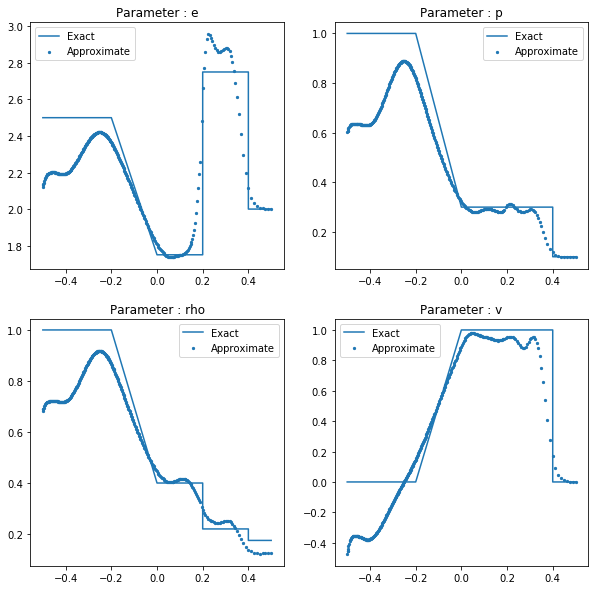

In [64]:
fig, ax = plt.subplots(2,2, figsize=(10,10))

mask = np.where(abs(np.array(data['x'])) <= 0.5)
mask = mask[0]

ax[0,0].plot(exact_e_x, exact_e_y)
ax[0,0].scatter(data['x'][mask], data['e'][mask], s=5)
ax[0,0].legend(['Exact', 'Approximate'])
ax[0,0].set_title('Parameter : e')

ax[0,1].plot(exact_p_x, exact_p_y)
ax[0,1].scatter(data['x'][mask], data['p'][mask], s=5)
ax[0,1].legend(['Exact', 'Approximate'])
ax[0,1].set_title('Parameter : p')

ax[1,0].plot(exact_rho_x, exact_rho_y)
ax[1,0].scatter(data['x'][mask], data['rho'][mask], s=5)
ax[1,0].legend(['Exact', 'Approximate'])
ax[1,0].set_title('Parameter : rho')

ax[1,1].plot(exact_v_x, exact_v_y)
ax[1,1].scatter(data['x'][mask], data['v'][mask], s=5)
ax[1,1].legend(['Exact', 'Approximate'])
ax[1,1].set_title('Parameter : v')

In [73]:
left = np.linspace(-0.5,0,320)
right = np.linspace(0,0.5,40)[1:]
h = 2*(right[1] - right[0])
x = np.append(left, right)
rho = np.append(np.ones_like(left), np.ones_like(right)*0.125)
p = np.append(np.ones_like(left), np.ones_like(right)*0.1)
v = np.zeros_like(x)
tag = np.ones_like(x)
tag[:3] = 0
tag[-3:] = 0
gamma = 1.4
epsilon = 1.0
eta = 0.1 * h
m =0.0015625000000000

st = Shocktube(x = x, p = p, rho = rho, \
               v = v, m = m, h = h, gamma = gamma, \
               epsilon = epsilon, eta = eta, kernel = cubic_spline, tag = tag)

In [74]:
for i in range(2000):
    st.update_euler_SD(dt = 1e-04)
    print i

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

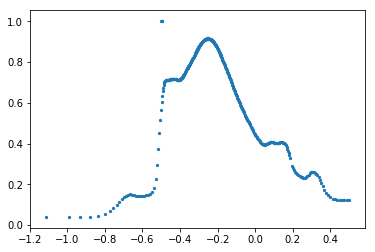

In [75]:
plt.scatter(st.x, st.rho, s=5)

Text(0.5,1,'Parameter : v')

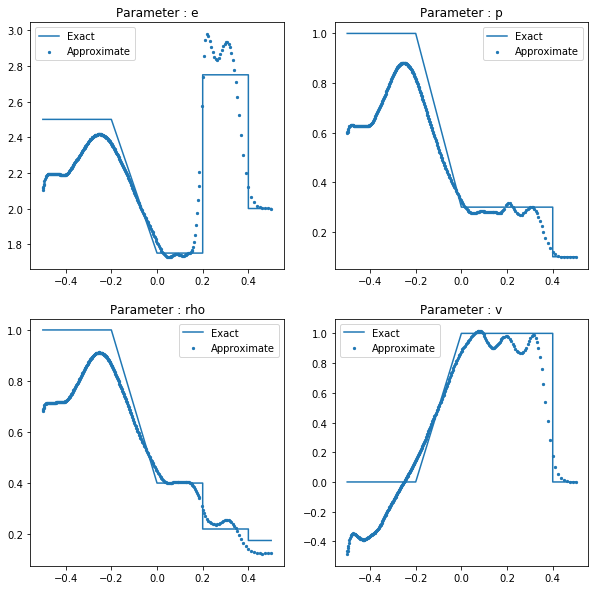

In [76]:
data = dict()
data['rho'] = st.get_xsph_approx('rho')
data['p'] = st.get_xsph_approx('p')
data['v'] = st.get_xsph_approx('v')
data['x'] = st.x
data['e'] = st.get_xsph_approx('e')

fig, ax = plt.subplots(2,2, figsize=(10,10))

mask = np.where(abs(np.array(data['x'])) <= 0.5)
mask = mask[0]

ax[0,0].plot(exact_e_x, exact_e_y)
ax[0,0].scatter(data['x'][mask], data['e'][mask], s=5)
ax[0,0].legend(['Exact', 'Approximate'])
ax[0,0].set_title('Parameter : e')

ax[0,1].plot(exact_p_x, exact_p_y)
ax[0,1].scatter(data['x'][mask], data['p'][mask], s=5)
ax[0,1].legend(['Exact', 'Approximate'])
ax[0,1].set_title('Parameter : p')

ax[1,0].plot(exact_rho_x, exact_rho_y)
ax[1,0].scatter(data['x'][mask], data['rho'][mask], s=5)
ax[1,0].legend(['Exact', 'Approximate'])
ax[1,0].set_title('Parameter : rho')

ax[1,1].plot(exact_v_x, exact_v_y)
ax[1,1].scatter(data['x'][mask], data['v'][mask], s=5)
ax[1,1].legend(['Exact', 'Approximate'])
ax[1,1].set_title('Parameter : v')

In [77]:
for key in data.keys():
    data[key] = list(data[key])

with open('shocktube_SD_with_boundary_epsilon_1.json', 'w') as shock:
    json.dump(data, shock)

In [79]:
st.x

array([-0.5       , -0.4984326 , -0.4968652 , -1.11325218, -0.98983346,
       -0.93342768, -0.8804665 , -0.83619034, -0.80130104, -0.77472098,
       -0.754367  , -0.73755495, -0.72298615, -0.71012879, -0.69847418,
       -0.68765849, -0.67731366, -0.66709784, -0.65680711, -0.64631076,
       -0.63554828, -0.62457501, -0.61352421, -0.6025201 , -0.59162726,
       -0.58086154, -0.57022752, -0.55975734, -0.54951694, -0.53964077,
       -0.53045988, -0.52242922, -0.51578009, -0.51036193, -0.50587794,
       -0.50206116, -0.49871355, -0.49569163, -0.49289633, -0.49026911,
       -0.48777187, -0.485375  , -0.48305477, -0.48079206, -0.47857111,
       -0.47637887, -0.47420465, -0.47204005, -0.46987863, -0.46771554,
       -0.46554727, -0.46337163, -0.46118765, -0.45899555, -0.45679681,
       -0.45459387, -0.45238963, -0.45018694, -0.44798831, -0.44579566,
       -0.4436102 , -0.44143247, -0.43926236, -0.43709912, -0.43494146,
       -0.43278761, -0.43063551, -0.42848298, -0.4263278 , -0.42